# CNN for Fundamental Respiration Sound Recognition

### Introduction

In this Norebook we developed a simple convolutional neural network (CNN) and trained it to recognize the fundamental respiration sounds, inspiration and expiration.

### Libraries Needed

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential

from ipywidgets import widgets, interact

import pandas as pd
import numpy as np
import librosa as lb
from tqdm import tqdm
from scipy import signal as sg
import soundfile as sfile
import librosa.display as lbdis
import matplotlib.pyplot as plt
%matplotlib inline


# changing to database path
import os
import sys
from os.path import dirname as up
mf_path = (up(os.getcwd())).replace('\\','/')    # Main Folder Path
sys.path.insert(1, mf_path)

import aidiagnostics_toolbox as aidt
import glob
os.chdir(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files')

### Functions Needed

In [2]:
# Functions Needed
def spec_to_chunk(long_spectrogram, tc=0.1, fs=2000):
    '''
    organise dataset for NN
    input: 
        long_spectrogram: spectrogram matrix containing the whole recordings sticked to each other
        tc: time-chunk 
    '''
    chunks = int(fs*tc) # number of samples in a time 't' at 2kHz sampling freq.    
    ex = int(long_spectrogram.shape[1]/chunks) # Number of examples per vector
    mat_s = np.zeros((ex,long_spectrogram.shape[0],chunks))   # Spectrogram matrix    
    for i in range(ex):
        mat_s[i,:,:] = long_spectrogram[:,i*chunks:(1+i)*chunks]
    return mat_s

def predictions_to_vector(Xin, predictions):
    out = np.zeros([Xin.shape[0], Xin.shape[2]])
    for i in tqdm(range(Xin.shape[0])):
        po = np.argmax(predictions[i])
        if po == 0:
            out[i,:] = po
        if po == 1:
            out[i,:] = po
        if po == 2:
            out[i,:] = po
        if po == 3:
            out[i,:] = po
        if po == 4:
            out[i,:] = po+1
        if po == 5:
            out[i,:] = po+1
    return out

### Data Loading Process

Lets first import is the **aidiagnostics_labels.csv** file which contain the labels for patient 105 sound recording. 

In [3]:
lp = mf_path + '/aidiagnostics_labels.csv'
lbs = pd.read_csv(lp)                 #  Labels 
sn = np.array(lbs.columns.values)     #  Names of recordings labelled

print('sound labelled: ', sn[0])

sound labelled:  105_1b1_Tc_sc_Meditron


Then lets upload the waveform and the actual label vector.

In [4]:
# Initializing Variables
sound_reco = []
sf_reco = []
sound_lbs = []
p=0
# Loading Loop
for file in tqdm(sn):
    data, sf = sfile.read(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files/' + file + '.wav')
    data = data[0:sf*int(data.shape[0]/sf)]
    sound_reco.append(data)
    sf_reco.append(sf)
    # loading labels
    po = np.array(lbs.iloc[:,p])
    po = po[~np.isnan(po)]
    sound_lbs.append(po[0:sf*int(data.shape[0]/sf)])
    p += 1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.63it/s]


Now, lets normalize the amplitude of the recording and then see how the labels look over the signal.

C:\Users\kevin\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


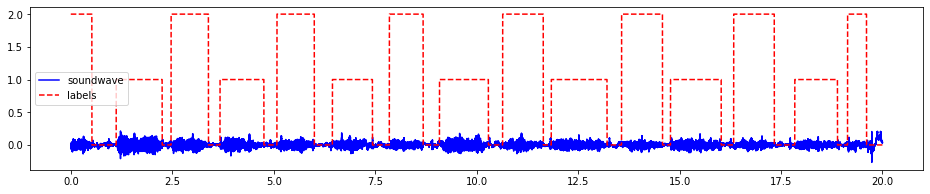

In [5]:
# Data Normalization
X = np.divide(data, max(data))
X = X - np.mean(X)
X = np.divide(X, np.max(X))

vtn = np.linspace(0,len(X)/sf,len(X))
# Ploting 
plt.figure(figsize=(16,3))
plt.plot(vtn, sound_reco[0], 'b', label = 'soundwave')#, label = 'waveform')
plt.plot(vtn, sound_lbs[0], 'r--', label = 'labels')
plt.legend()
plt.show()

### A kind of Data Augmentation

Whenever there is no enough data to train our models we can develop a data augmentation procedure. In this case, from a sigle sound we will generate 4 images: a Spectrogram, a Mel Spectrogram, the Harmonics and the Percussive os a Mel Spectrogram.

Lets calculate the spectrogram first

In [6]:
# Calculate Spectrogram

Now, lets calculate the Mel-Spectrogram, its Harmonics and Percussive form

In [7]:
# Mel spectrogram
Mspec = lb.feature.melspectrogram(X, sr=sf, n_mels=128)
# Convert to log scale (dB)
Mspec_db = lb.power_to_db(Mspec, ref=np.max)

# Harmonic & Percussive
y_harmonic, y_percussive = lb.effects.hpss(X)

S_harmonic   = lb.feature.melspectrogram(y_harmonic)
S_percussive = lb.feature.melspectrogram(y_percussive)

# Convert to log scale (dB). We'll use the peak power as reference.
harmonic_mspec = lb.power_to_db(S_harmonic, ref=np.max)
percussive_mspec = lb.power_to_db(S_percussive, ref=np.max)

now we can plot the augmented data, each of them with the same label vector

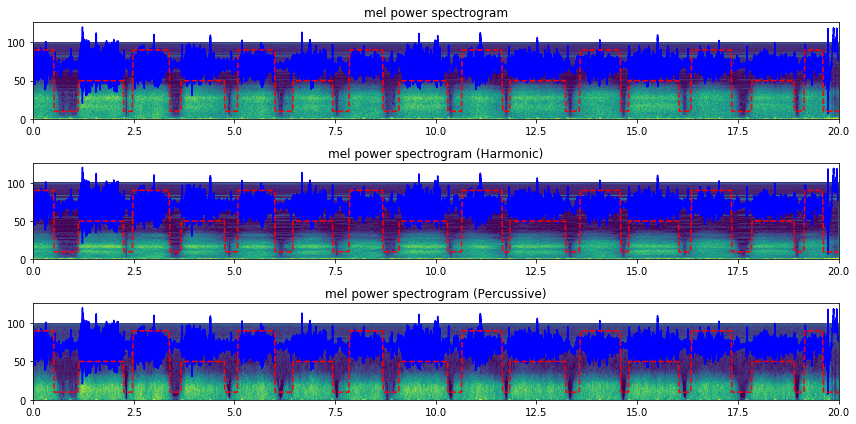

In [8]:
# Resize sound labels
r_label = np.round(sg.resample(sound_lbs[0], Mspec_db.shape[1]))
# Time vector for resampled signals
vtr = np.linspace(0, len(X)/sf, Mspec_db.shape[1])

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.imshow(Mspec_db, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(vtn, 70 + 50* X, 'b')
plt.plot(vtr, 10 + 40* r_label, 'r--')
plt.title('mel power spectrogram')
plt.subplot(3,1,2)
plt.imshow(harmonic_mspec, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(vtn, 70 + 50* X, 'b')
plt.plot(vtr, 10 + 40* r_label, 'r--')
plt.title('mel power spectrogram (Harmonic)')
plt.subplot(3,1,3)
plt.imshow(percussive_mspec, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(vtn, 70 + 50* X, 'b')
plt.plot(vtr, 10 + 40* r_label, 'r--')
plt.title('mel power spectrogram (Percussive)')
plt.tight_layout()

### Model Input Preparation
Before building and training our model, we have to prepare what it would be the input for the network

In [9]:
all_spec = []
all_lb = []

all_spec.append(Mspec_db)
all_spec.append(harmonic_mspec)
all_spec.append(percussive_mspec)

all_lb.append(r_label)
all_lb.append(r_label)
all_lb.append(r_label)

print(np.shape(all_spec), np.shape(all_lb))

(3, 128, 1723) (3, 1723)


In [10]:
#all_spec = [[Mspec_db],[log_Sp],[log_Sh]]
#all_lb = np.array([[r_label],[r_label],[r_label]])
# Dividing data into 70% training and 30% validation
train_vectorS_spec, train_vectorL, val_vectorS_spec, val_vectorL = aidt.hs_longSpec(all_spec, all_lb, pc=0.70)
# Mel Spectrogram Normalization 
train_vectorS_spec = -1*train_vectorS_spec/80
val_vectorS_spec = -1*val_vectorS_spec/80
# Generating chunks for Spectrogram
train_spec, train_t3 = aidt.nn_org_dataset_spec(train_vectorS_spec, train_vectorL, tc=0.005)
val_spec, val_t3 = aidt.nn_org_dataset_spec(val_vectorS_spec, val_vectorL, tc=0.005)

# Generating 3-dimention label vectors
train_t_f_3 = aidt.sq_labels_4(train_t3)
val_t_f_3 = aidt.sq_labels_4(val_t3)

# Adding Extra Dimension for CNN Model
train_spec_CNN = np.expand_dims(train_spec, axis=3)
val_spec_CNN = np.expand_dims(val_spec, axis=3)

#in_size = train_d.shape[1]
flat_size = train_spec.shape[2]*train_spec.shape[2]

print(train_spec.shape)

(128, 3618)
(3618,)
(361, 128, 10)


In [11]:
print(train_spec.shape)

(361, 128, 10)


### Developing CNN Model in Tensorflow

In [14]:

def CNN_1():
    model = tf.keras.Sequential ([
        tf.keras.layers.Conv2D(4, 4, padding='same', activation='relu', input_shape=(train_spec.shape[1], train_spec.shape[2] ,1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(4, 4, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(flat_size, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
    mse = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=opt,
                 loss=mse,
                 metrics=['accuracy','mae'])
    return model

fureso_v1 = CNN_1()
fureso_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 10, 4)        68        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 5, 4)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 5, 4)          260       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 2, 4)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [15]:
#best_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
checkpoint_path = mf_path + '/saved_model/CNN.ckpt'
best_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, save_best_only=True,
                                                 monitor='val_loss', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
history_2 = fureso_v1.fit(train_spec_CNN, train_t_f_3, epochs=50, batch_size=4, validation_data=(val_spec_CNN, val_t_f_3), callbacks = [early_stop, best_save])

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.4709 - mae: 0.4166 - mse: 0.2079
Epoch 00001: val_loss improved from inf to 0.19538, saving model to C:/Users/kevin/Desktop/AIDiagnostics/AID_opensource/Fundamental_Respiration_Sounds.ckpt
91/91 [==============================] - 1s 10ms/step - loss: 0.2082 - accuracy: 0.4709 - mae: 0.4166 - mse: 0.2079 - val_loss: 0.1954 - val_accuracy: 0.5355 - val_mae: 0.4102 - val_mse: 0.1955
Epoch 2/50
89/91 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.6236 - mae: 0.3539 - mse: 0.1726
Epoch 00002: val_loss improved from 0.19538 to 0.18347, saving model to C:/Users/kevin/Desktop/AIDiagnostics/AID_opensource/Fundamental_Respiration_Sounds.ckpt
91/91 [==============================] - 1s 6ms/step - loss: 0.1737 - accuracy: 0.6233 - mae: 0.3541 - mse: 0.1728 - val_loss: 0.1835 - val_accuracy: 0.5355 - val_mae: 0.3728 - val_mse: 0.1837
Epoch 3/50
87/91 [===========================>..] - E

Epoch 20/50
86/91 [===========================>..] - ETA: 0s - loss: 0.0664 - accuracy: 0.8547 - mae: 0.1456 - mse: 0.0664
Epoch 00020: val_loss improved from 0.08321 to 0.07853, saving model to C:/Users/kevin/Desktop/AIDiagnostics/AID_opensource/Fundamental_Respiration_Sounds.ckpt
91/91 [==============================] - 1s 6ms/step - loss: 0.0656 - accuracy: 0.8560 - mae: 0.1439 - mse: 0.0661 - val_loss: 0.0785 - val_accuracy: 0.8387 - val_mae: 0.1545 - val_mse: 0.0787
Epoch 21/50
90/91 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.8556 - mae: 0.1504 - mse: 0.0747
Epoch 00021: val_loss did not improve from 0.07853
91/91 [==============================] - 1s 7ms/step - loss: 0.0740 - accuracy: 0.8560 - mae: 0.1502 - mse: 0.0745 - val_loss: 0.0966 - val_accuracy: 0.8258 - val_mae: 0.1641 - val_mse: 0.0960
Epoch 22/50
82/91 [==========================>...] - ETA: 0s - loss: 0.0738 - accuracy: 0.8445 - mae: 0.1510 - mse: 0.0738
Epoch 00022: val_loss did not impr

### Create a new untrained model
As mentioned in Tensorflow tutorials "When restoring a model from weights-only, you must have a model with the same architecture as the original model". Therefore, we will create a new model with the same arquitecture, check the results without any training, then upload the saved weiths from our trained model and see the new results

In [31]:
# Creating the Model
fureso_v2 = CNN_1()
# Evaluating the model
history = fureso_v2.evaluate(train_spec_CNN, train_t_f_3, verbose = 2)
# Getting results
loss, acc = history[0], history[1]
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

12/12 - 0s
Untrained model, accuracy: 44.88%


Now, lets load the weights from the trained model checkpoint and evaluate again

In [41]:
# Loading Weights
fureso_v2.load_weights(mf_path+'.ckpt')
# evaluating model
history = fureso_v2.evaluate(train_spec_CNN,  train_t_f_3, verbose=2)
loss, acc = history[0], history[1]
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

12/12 - 0s
Restored model, accuracy: 91.14%


### Results

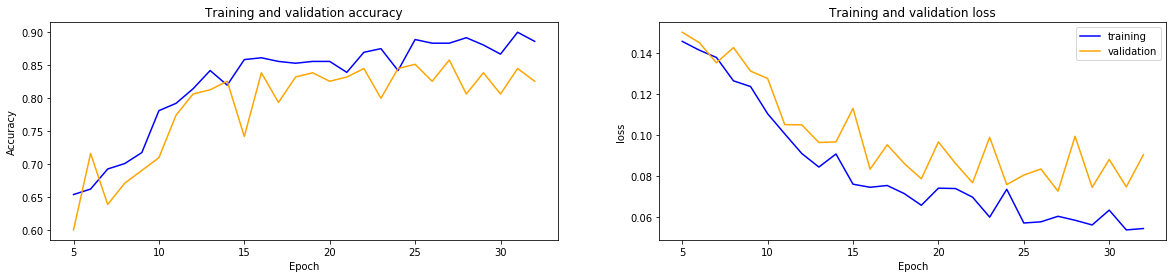

In [16]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
epochs_2 = range(len(acc_2))

plt.figure(figsize=(20,4))
# Plot accuracy vs epochs
plt.subplot(1,2,1)
plt.title('Training and validation accuracy')
plt.plot(epochs_2[5:], acc_2[5:], color='blue', label='training')
plt.plot(epochs_2[5:], val_acc_2[5:], color='orange', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot loss vs epochs
plt.subplot(1,2,2)
plt.title('Training and validation loss')
plt.plot(epochs_2[5:], loss_2[5:], color='blue', label='training')
plt.plot(epochs_2[5:], val_loss_2[5:], color='orange', label='validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 154937.35it/s]


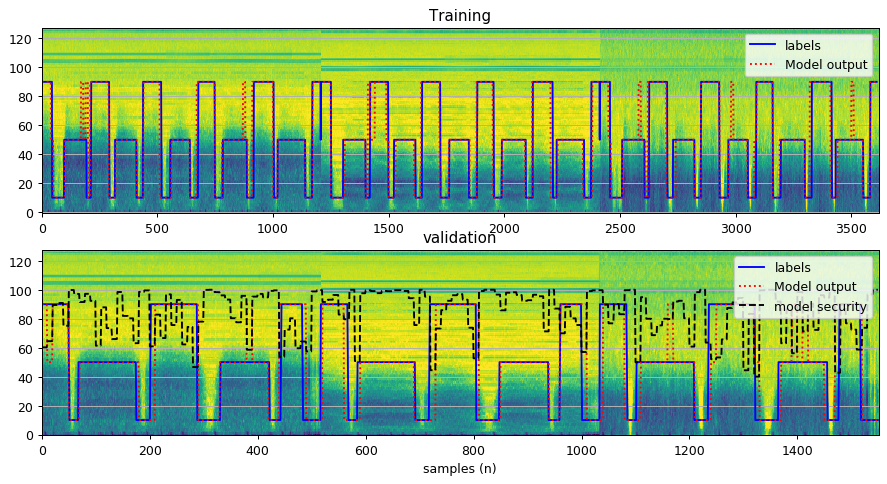

In [42]:
train_predictions_2 = fureso_v2.predict(train_spec_CNN)
val_predictions_2 = fureso_v2.predict(val_spec_CNN)

train_pred_2 = aidt.back_to_long_labels(train_t3,train_predictions_2)
val_pred_2 = aidt.back_to_long_labels(val_t3,val_predictions_2)

train_pred_2 = train_pred_2.flatten()
val_pred_2 = val_pred_2.flatten()

def long_labels(Xin, predictions):
    out = np.zeros([Xin.shape[0], Xin.shape[1]])
    for i in tqdm(range(np.shape(predictions)[0])):
        out[i,:] = max(predictions[i])
    return out.flatten()

secure = long_labels(val_t3, val_predictions_2)
# -----------------------------------------------------------------------------
plt.figure(num=1, figsize=(12, 6), dpi=90, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.imshow(train_vectorS_spec, origin='lower', cmap='viridis', aspect='auto')


plt.plot(10 + 40*train_t3.flatten(),'b', label='labels',markersize=10)
plt.plot(10 + 40*train_pred_2,'r:', label='Model output')
#plt.plot(vtn, X, 'b')
plt.gca().yaxis.grid(True)
plt.title('Training')
plt.legend()

plt.subplot(2,1,2)
plt.imshow(val_vectorS_spec, origin='lower', cmap='viridis', aspect='auto')

plt.plot(10 + 40*val_t3.flatten(),'b', label='labels',markersize=10)
plt.plot(10 + 40*val_pred_2, 'r:',label='Model output')
plt.plot(100*secure, 'k--',label = 'model security')
#plt.plot(vtn, X, 'b')
plt.gca().yaxis.grid(True)
plt.title('validation')
plt.xlabel('samples (n)')
plt.legend(loc='upper right')

C:\Users\kevin\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


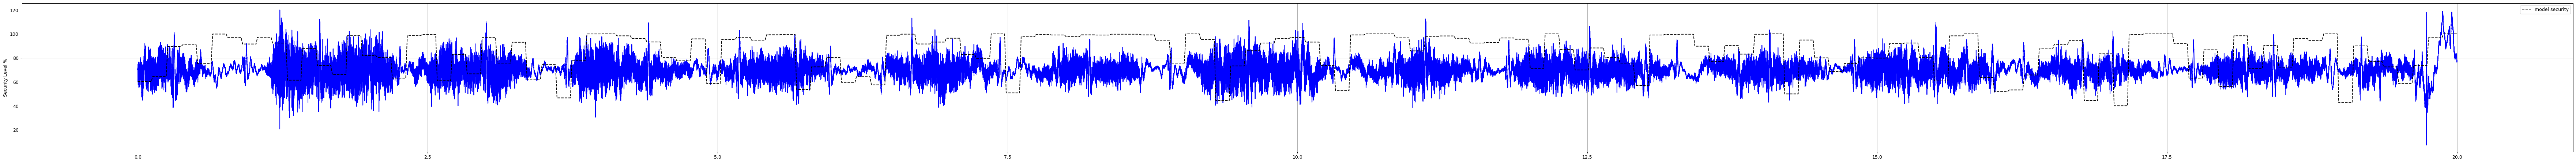

In [43]:
plt.figure(num=1, figsize=(100, 6), dpi=90, facecolor='w', edgecolor='k')
plt.plot(vtn, 70 + 50* X, 'b')
plt.plot(np.linspace(0, len(X)/sf, len(secure)), 100*secure, 'k--', label = 'model security')
plt.ylabel('Security Level %')
plt.legend()
plt.grid(True)
plt.show()

### Testing Model with Unseen Sounds

C:\Users\kevin\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


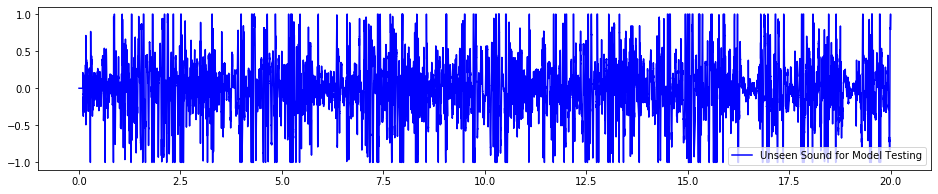

In [44]:
test_sound, test_sf = sfile.read(mf_path + '/Respiratory_Sound_Database/audio_and_txt_files/107_2b3_Ar_mc_AKGC417L.wav')
test_sound = test_sound[0:sf*int(len(test_sound)/test_sf)]
# Data Normalization
test_sound = np.divide(test_sound, max(test_sound))
test_sound = test_sound - np.mean(test_sound)
test_sound = np.divide(test_sound, np.max(test_sound))


vt_T = np.linspace(0,len(test_sound)/sf,len(test_sound))
# Ploting 
plt.figure(figsize=(16,3))
plt.plot(vt_T, test_sound, 'b', label = 'Unseen Sound for Model Testing')#, label = 'waveform')
plt.legend()
plt.show()

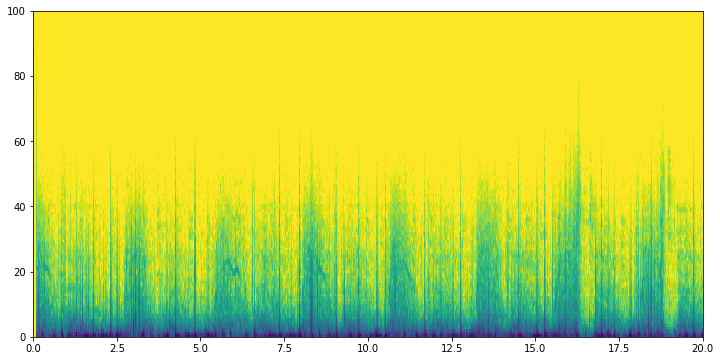

In [45]:
# Mel spectrogram
Mspec_test = lb.feature.melspectrogram(test_sound, sr=sf, n_mels=128)
# Convert to log scale (dB)
Mspec_test = lb.power_to_db(Mspec_test, ref=np.max)
# M-Spectrogram Normalization
Mspec_test = -1*Mspec_test/80

# Adding Extra Dimension for CNN Model
test_mInput = np.expand_dims(spec_to_chunk(Mspec_test, tc = 0.005), axis=3)

plt.figure(figsize=(12,6))

plt.imshow(Mspec_test, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))

100%|█████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 85965.24it/s]


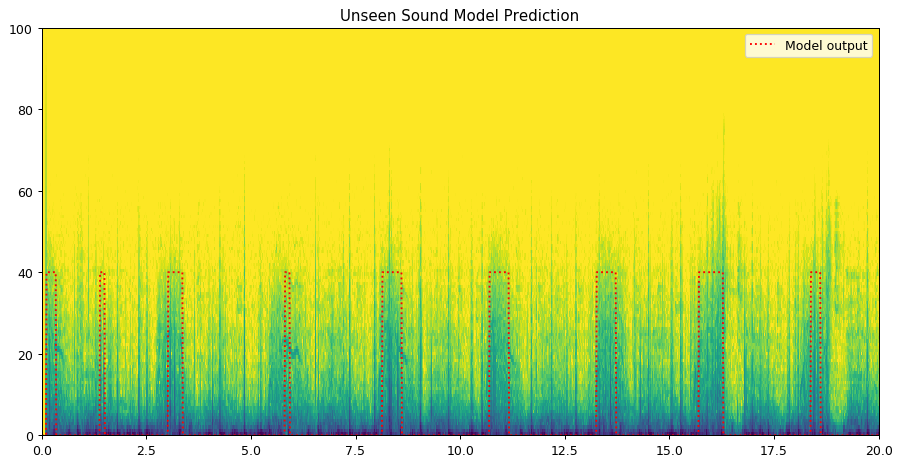

In [46]:
#test_spec = np.expand_dims(spec_to_chunk(test_vS, tc = 0.04), axis=3)
test_predictions = fureso_v1.predict(test_mInput)
test_pred = predictions_to_vector(test_mInput, test_predictions)
test_pred = test_pred.flatten()

plt.figure(num=1, figsize=(12, 6), dpi=90, facecolor='w', edgecolor='k')
#plt.imshow(Mspec_test, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.imshow(Mspec_test, origin='lower', cmap='viridis', aspect='auto',extent=(0, len(X)/sf, 0, sf / sf * 100))
plt.plot(np.linspace(0, len(test_sound)/sf, len(test_pred)), 20*test_pred,'r:', label='Model output')
#plt.plot(test_sound,'b', label='labels',markersize=10)

plt.title('Unseen Sound Model Prediction')
#plt.ylabel('category (S1,S2,Sy,Di)')
plt.legend()